In [1]:
import pandas as pd

In [2]:
import pickle

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error

In [5]:
df_january = pd.read_parquet('../data/yellow_tripdata_2023-01.parquet')

Q1: Download the data for January and February 2023.

Read the data for January. How many columns are there?

In [6]:
df_january

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.30,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.90,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.90,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.10,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.40,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3066761,2,2023-01-31 23:58:34,2023-02-01 00:12:33,NaN,3.05,NaN,None,107,48,0,15.80,0.00,0.5,3.96,0.0,1.0,23.76,NaN,NaN
3066762,2,2023-01-31 23:31:09,2023-01-31 23:50:36,NaN,5.80,NaN,None,112,75,0,22.43,0.00,0.5,2.64,0.0,1.0,29.07,NaN,NaN
3066763,2,2023-01-31 23:01:05,2023-01-31 23:25:36,NaN,4.67,NaN,None,114,239,0,17.61,0.00,0.5,5.32,0.0,1.0,26.93,NaN,NaN
3066764,2,2023-01-31 23:40:00,2023-01-31 23:53:00,NaN,3.15,NaN,None,230,79,0,18.15,0.00,0.5,4.43,0.0,1.0,26.58,NaN,NaN


A1: 19

Q2: Now let's compute the duration variable. It should contain the duration of a ride in minutes.

What's the standard deviation of the trips duration in January?

In [7]:
df_january['duration'] = df_january.tpep_dropoff_datetime - df_january.tpep_pickup_datetime
df_january.duration = df_january.duration.apply(lambda td: td.total_seconds() / 60)

In [8]:
df_january.duration.std()

42.594351241920904

A2: 42.59

Q3: Next, we need to check the distribution of the duration variable. There are some outliers. Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).

What fraction of the records left after you dropped the outliers?

In [10]:
df_january[(df_january.duration >= 1) & (df_january.duration <= 60)].shape[0]/df_january.shape[0]


0.9812202822125979

In [12]:
df_january = df_january[(df_january.duration >= 1) & (df_january.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df_january[categorical] = df_january[categorical].astype(str)

/tmp/ipykernel_5889/460715423.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_january[categorical] = df_january[categorical].astype(str)


A3: 98%

Q4: Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model.

Turn the dataframe into a list of dictionaries (remember to re-cast the ids to strings - otherwise it will label encode them)

Fit a dictionary vectorizer

Get a feature matrix from it

What's the dimensionality of this matrix (number of columns)?

In [13]:
train_dicts = df_january[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df_january[target].values

In [14]:
len(dv.feature_names_)

516

A4: 515

Q5: Now let's use the feature matrix from the previous step to train a model.

Train a plain linear regression model with default parameters, where duration is the response variable
Calculate the RMSE of the model on the training data
What's the RMSE on train?

In [15]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

7.658390530899328

A5: 7.64

/tmp/ipykernel_5889/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_5889/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


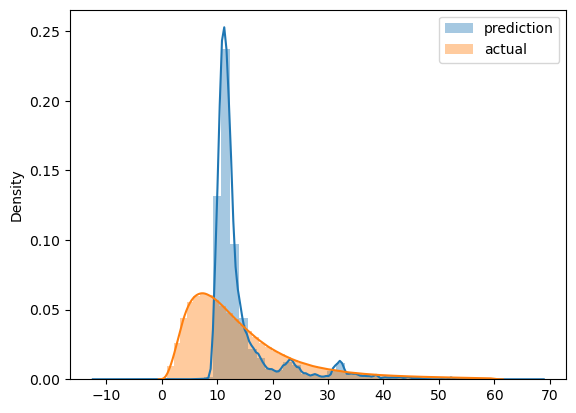

In [16]:
sns.displot(y_pred, label='prediction')
sns.displot(y_train, label='actual')

plt.legend()

In [17]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)
        df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [18]:
df_february = read_dataframe('../data/yellow_tripdata_2023-02.parquet')

In [19]:
df_february['PU_DO'] = df_february['PULocationID'] + '_' + df_february['DOLocationID']


In [20]:
val_dicts = df_february[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [21]:
y_val = df_february[target].values

Q6:Now let's apply this model to the validation dataset (February 2023).

What's the RMSE on validation?



In [22]:
y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

7.820315880150861

A6: 7.81

In [24]:
with open('../models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [25]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

8.137900681701906